In [46]:
from dotenv import load_dotenv

load_dotenv()

True

In [47]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", streaming=True )
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [48]:
from langchain_core.tools import tool

@tool
def add(a:int, b:int) -> int:
    """ 
    숫자 a와 b를 더합니다.
    """
    return a+b

@tool
def multiple(a:int, b:int) -> int:
    """ 
    숫자 a와 b를 곱합니다.
    """
    return a*b

In [49]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiple]
llm_with_tools = llm.bind_tools(tool_list) #llm이 어떤 tool을 사용해야할지 결정함. Message로 반환
tool_node = ToolNode(tool_list) # Message를 기반으로 자동으로 tool을 실행(호출)하는 노드

In [50]:
ai_message = llm_with_tools.invoke("What is 3 plus 5?")

In [51]:
ai_message # tool이 호출됨

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_WIFrTfay8wlhhh6UONIERIRX', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567'}, id='run--5f5d3097-9503-46e2-87bc-41fdf633111d-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_WIFrTfay8wlhhh6UONIERIRX', 'type': 'tool_call'}])

In [52]:
tool_node.invoke({'messages':[ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_WIFrTfay8wlhhh6UONIERIRX')]}

In [53]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState) #Messages 가 안에 존재

In [54]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]} #MessagesState의 특징으로 append하는 것 처럼 추가됨.

In [55]:
from typing import Literal
from langgraph.graph import START, END

def should_continue(state: MessagesState) -> Literal['tools', END]: #END로 넣는 것이 가능하다. END는 상수 객체
    messages = state['messages']
    last_ai_messages = messages[-1]

    if last_ai_messages.tool_calls:
        return 'tools'
    
    return END

In [56]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [57]:
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
    # {
    #     'tools' : "tools",
    #     'end' : END
    # }
)

graph_builder.add_edge('tools', 'agent')

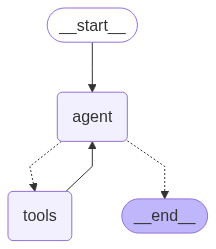

In [58]:
graph = graph_builder.compile()
graph

In [59]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

for chunk in graph.stream({'messages' : [HumanMessage('3에다 5을 더하고 거기에 8을 곱하면?')]}, stream_mode='values'): #invoke 와 비슷, stream으로 받음
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5을 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_4rvarzrJtUalNmTfeD9SAvuP)
 Call ID: call_4rvarzrJtUalNmTfeD9SAvuP
  Args:
    a: 3
    b: 5
  multiple (call_kWXKGO9LH8OzcDBAR4E1jBgT)
 Call ID: call_kWXKGO9LH8OzcDBAR4E1jBgT
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiple

64
================================== Ai Message ==================================
Tool Calls:
  multiple (call_aeolCA6I2w8iGKZEeEsxf0ok)
 Call ID: call_aeolCA6I2w8iGKZEeEsxf0ok
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiple

64
================================== Ai Message ==================================

3에 5를 더하면 8이 되고, 거기에 8을 곱하면 64가 됩니다.


## Google tool 추가

In [60]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [61]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

credentials = get_gmail_credentials(
    token_file="./google/google_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/google_credential.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [62]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x000001FDA795E2D0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001FDA795E2D0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x000001FDA795E2D0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001FDA795E2D0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x000001FDA795E2D0>)]

In [63]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiple, search_tool] + gmail_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [64]:
from langgraph.graph import MessagesState, StateGraph
from typing import Literal
from langgraph.graph import START, END

graph_builder = StateGraph(MessagesState) #Messages 가 안에 존재

def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]} #MessagesState의 특징으로 append하는 것 처럼 추가됨.

def should_continue(state: MessagesState) -> Literal['tools', END]: #END로 넣는 것이 가능하다. END는 상수 객체
    messages = state['messages']
    last_ai_messages = messages[-1]

    if last_ai_messages.tool_calls:
        return 'tools'
    
    return END

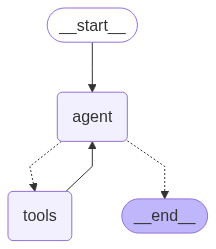

In [65]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
    # {
    #     'tools' : "tools",
    #     'end' : END
    # }
)

graph_builder.add_edge('tools', 'agent')

graph = graph_builder.compile()
graph

In [67]:
from langchain_core.messages import AIMessage, HumanMessage

query = "What currency is in 장원영's birthplace? Find the currency and email it to elioscode@gmail.com"

for chunk in graph.stream({'messages' : [HumanMessage(query)]}, stream_mode='values'): #invoke 와 비슷, stream으로 받음
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

What currency is in 장원영's birthplace? Find the currency and email it to elioscode@gmail.com
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_QL8DhCiMHijOSc6ysYM64eBl)
 Call ID: call_QL8DhCiMHijOSc6ysYM64eBl
  Args:
    query: 장원영 birthplace


c:\git_repo\GJ_class\uv_work\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

장원영 ( 2004 년 8월 31일 ~ ) 은 대한민국의 가수이다. 그녀는 스타쉽 엔터테인먼트 소속 의 대한민국 걸 그룹 아이브 의 멤버이자, 프로젝트 걸 그룹 아이즈원 의 ... IVE에서 대체불가 매력과 보컬을 맡고 있는 장원영입니다! 대한민국의 가수. 스타쉽엔터테인먼트 소속 6인조 걸그룹 IVE의 멤버. 장원영(張員瑛, 2004년 8월 31일~)은 대한민국의 가수로, 걸 그룹 IVE의 멤버이다. 장원영. 2023년 멜론 뮤직 어워드 당시의 장원영. 기본 정보. 2018년 8월 31일, 데뷔 멤버를 결정짓는 최종 순위발표식에서 1등을 하여 걸그룹 IZ*ONE으로 데뷔하였다. 상세 내용 아이콘.svg 자세한 내용은 장원영(IZ*ONE)/프로듀스 48 ... Jang Wonyoung (Korean: 장원영; Japanese: チャン・ウォニョン; or simply ... Birthplace. South Korea-Flagicon Ichon-dong, Yongsan-gu, Seoul, South Korea ...
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_MSpcXAtwV3yhycVtU8IbAjgo)
 Call ID: call_MSpcXAtwV3yhycVtU8IbAjgo
  Args:
    query: South Korea currency


c:\git_repo\GJ_class\uv_work\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

The South Korean won, sometimes known as the Republic of Korea won is the official currency of South Korea. A single won is divided into 100 jeon, ... The South Korean won is the official currency of South Korea. Its currency code is KRW and its symbol is ₩. The won's conversion factor goes to 6 significant ... KRW - South Korean Won ... Our currency rankings show that the most popular South Korean Won exchange rate is the KRW to USD rate. The currency code for South ... Coins come in 1, 5, 10, 100, and 500 won (1 and 5 won coins are not widely circulated). Korea's Bills. 1,000 won (cheon won). 1,000 won Front. Front. 1,000 won ... Currency in circulation. Legal Tender. These banknotes and coins were put into circulation between 1962 and 2009. Some of these currencies are no longer ...
================================== Ai Message ==================================
Tool Calls:
  se